# Test notebook for estimateing FD angles that tranform FT of TD CP moments into inertial frame FD moments

In [2]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import numpy as np
from numpy import *
from matplotlib.pyplot import *
from positive import *
from positive.units import *
from nrutils import scsearch,gwylm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(positive)>> Applying custom matplotlib settings.


In [3]:
# Find a catalog entry of interest using a keyword search
a = scsearch(keyword='q8a06t120',verbose=True)[0]

(scsearch)>> Found keyword (=q8a06t120) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 2 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t120dP2_T_96_384)
(scsearch)>> [0002][hogshead] q8precessing: 1chi0.60-p-q8.00	(q8a06t120dP2_T_96_384)



In [4]:
# Load the realted NR waveform
y = {}
lmax = 4
y['raw'] = gwylm(a,lmax=lmax,dt=0.5,clean=True,verbose=False,pad=2000,load_dynamics=True)

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.


In [5]:
# Generate waveform in J-of-t-frame (this rotates all multipoles and vector metadata)
y['j'] = y['raw'].__calc_j_of_t_frame__()

(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


In [27]:
yj = y['j']
yj.__lmlist__

In [6]:
# Compute TD CP frame and related info
y['cp-td'] = y['j'].__calc_coprecessing_frame__(transform_domain='td',kind='psi4')

(calc_coprecessing_angles)>> The domain values seem unevenly split between positive and negative values. Thus, we will interpret the input as corresponding to TIME DOMAIN data.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


In [7]:
# Extract frame info
foo = y['cp-td'].previous_radiation_axis_info

In [8]:
foo.__dict__.keys()

dict_keys(['gwylmo', 'select_lm_list', 'radiation_axis', 'save', 'process_td', 'process_fd', 'plot'])

In [9]:
td_alpha = foo.radiation_axis['td_alpha']
td_beta  = foo.radiation_axis['td_beta']
td_gamma = foo.radiation_axis['td_gamma']

In [161]:

    
#
def calc_alterior_angles_helper( lmlist, A,B, ALPHA, BETA, GAMMA ):

    '''

    Given 

    lmlist -- List (l,m) in same order in m as A and B inputs. l is fixed
    A -- Inertial momements at a single frequency 
    B -- Coprecessing moments at a single fequency (Fourier transform of TD coprecessing moments)

    ALPHA, BETA, GAMMA -- Euler angles for 3D rotation. Each is a dict containing eg alpha_lm with keys (l,m). These dictionaries encode 3*(2*l+1) angles :/

    Determine

    C -- The rotation of B by (-gamma,-beta,-alpha)
    MU -- a distance measurement between A and C

    Return

    MU -- single number 

    '''
    
    #
    from nrutils import rotate_wfarrs_at_all_times

    #
    C = []
    for k,(l,m) in enumerate(lmlist):

        #
        Cm = rotate_wfarrs_at_all_times( l,m, { (ll,mm):B[k] for k,(ll,mm) in enumerate(lmlist) }, (GAMMA,BETA,ALPHA),angles_are_alterior=True )
        C.append(Cm)
    #
    C = array(C)

    # Given C, estiamte the square "distance" between A and C
    MU = sum(abs(  (A[:,1]+1j*A[:,2])  -  (C[:,1]+1j*C[:,2])  )**2)

    #
    return MU


#
def calc_alterior_angles( inertial_frame_gwylmo, l, kind='psi4' ):
    '''
    
    INPUTS
    ---
    
    '''
    
    #
    from scipy.fftpack import fft, fftfreq, fftshift, ifft
    from nrutils.manipulate.rotate import wdelement#
    from scipy.optimize import minimize
    
    #
    lmlist = [ (ll,mm) for ll,mm in inertial_frame_gwylmo.__lmlist__ if ll==l]
    FT = lambda X: fftshift( fft( X ) )
    
    #
    frame = {}
    frame['input'] = inertial_frame_gwylmo
    frame['cp']    = frame['input'].__calc_coprecessing_frame__(transform_domain='td',kind=kind)
    
    #
    f_domain = frame['cp'].f
    
    #
    NumM = (2*l+1)
    LENX = 3*NumM
    X   = []
    ERR = []
    
    #
    for k,f in enumerate(f_domain):
    
    
        '''
        * We will consider the k'th frequency bin
        * Let Alm be the inertial frame multipole moments at a single frequency bin
        * Let Blm be the coprecessing frame moments at a single frequency bin 
        '''
        A = array([ frame['input'][l,m][kind].fd_wfarr[k,:] for l,m in lmlist ])
        B = array([ frame['cp'   ][l,m][kind].fd_wfarr[k,:] for l,m in lmlist ])
        
        #
        def action(X):
            
            #
            lenX = len(X)
            if lenX != LENX:
                error('input must have length of 3*(2*l+1)=%i'%(LENX))
            if mod(lenX,3):
                error('input must be have len of intege multiple of 3')
                
            # Create lists by unpacking vectorized input 
            alpha_list  = X[        0 : NumM     ]
            beta_list   = X[     NumM : (2*NumM) ]
            gamma_list  = X[ (2*NumM) : (3*NumM) ]
            
            # Create dicts by assuming m ordering in lmlist
            ALPHA = { mp:alpha_list[j] for j,(_,mp) in enumerate(lmlist) }
            BETA  = { mp:beta_list[ j]  for j,(_,mp) in enumerate(lmlist) }
            GAMMA = { mp:gamma_list[j] for j,(_,mp) in enumerate(lmlist) }
            
            # Calculate and return distance estimate
            return calc_alterior_angles_helper( lmlist, A,B, ALPHA, BETA, GAMMA )
        
        #
        initial_guess = zeros_like(range(0,LENX))
        if k>0: initial_guess = mu.x
        mu = minimize( action, initial_guess  )
        
        X.append(mu.x)
        ERR.append(mu.fun)
        if mod(k,300)==0:
            print('.%1.0f..'%(100*float(k)/len(f_domain)),end='')
        
    #
    return (X,ERR)
        
            
    

In [163]:
l = 3
foo3 = calc_alterior_angles( y['j'], l )

(calc_coprecessing_angles)>> The domain values seem unevenly split between positive and negative values. Thus, we will interpret the input as corresponding to TIME DOMAIN data.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
.0...4...8...12...15...19...23...27...31...35...39...43...46...50...54...58...62...66...70...74...77...81...85...89...93...97..

In [112]:
l = 2
foo = calc_alterior_angles( y['j'], l )

(calc_coprecessing_angles)>> The domain values seem unevenly split between positive and negative values. Thus, we will interpret the input as corresponding to TIME DOMAIN data.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [179]:
X3 = array(foo3[0])

#
NumM = (2*3+1)
lmlist3 = [ (ll,mm) for ll,mm in y['j'].__lmlist__ if ll==3 ]
    
# Create lists by unpacking vectorized input 
alpha_list  = X3[:,        0 : NumM     ]
beta_list   = X3[:,     NumM : (2*NumM) ]
gamma_list  = X3[:, (2*NumM) : (3*NumM) ]

# Create dicts by assuming m ordering in lmlist
ALPHA3 = { (ll,mp):alpha_list[:,j] for j,(ll,mp) in enumerate(lmlist3) }
BETA3  = { (ll,mp):beta_list[ :,j]  for j,(ll,mp) in enumerate(lmlist3) }
GAMMA3 = { (ll,mp):gamma_list[:,j] for j,(ll,mp) in enumerate(lmlist3) }

In [180]:
X = array(foo[0])

#
NumM = (2*2+1)
lmlist2 = [ (ll,mm) for ll,mm in y['j'].__lmlist__ if ll==2 ]
    
# Create lists by unpacking vectorized input 
alpha_list  = X[:,        0 : NumM     ]
beta_list   = X[:,     NumM : (2*NumM) ]
gamma_list  = X[:, (2*NumM) : (3*NumM) ]

# Create dicts by assuming m ordering in lmlist
ALPHA = { (ll,mp):alpha_list[:,j] for j,(ll,mp) in enumerate(lmlist2) }
BETA  = { (ll,mp):beta_list[ :,j]  for j,(ll,mp) in enumerate(lmlist2) }
GAMMA = { (ll,mp):gamma_list[:,j] for j,(ll,mp) in enumerate(lmlist2) }

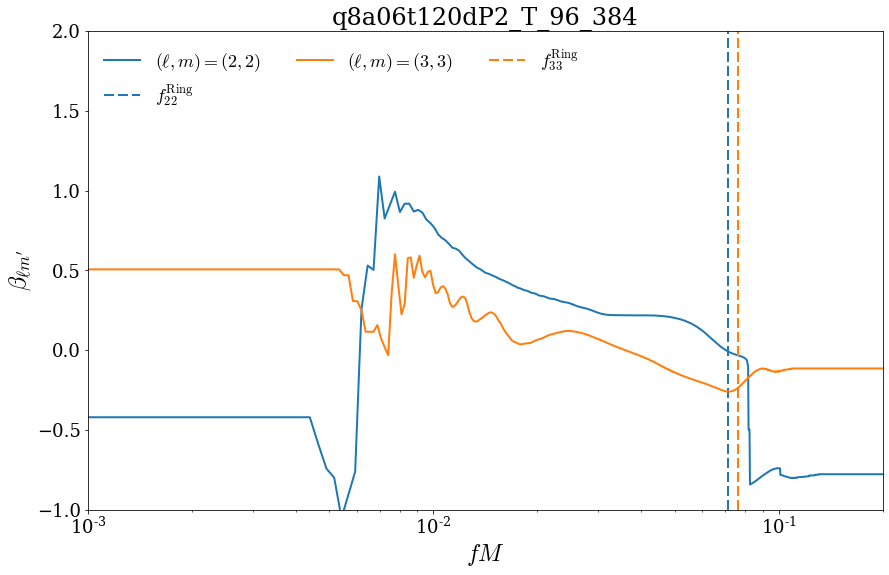

In [210]:


figure( figsize=2.2*figaspect(0.618) )

f = y['j'].f
mask = (f>0.01) & (f<0.1)
center = lambda aa: aa - mean(aa[mask])

for l,m in lmlist2+lmlist3:
    if l==(m):
        if (l,m) in BETA:
            p=plot( (y['j'].f), center(-unwrap(ALPHA[l,m])), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )
            axvline( abs(y['j'][l,m]['psi4'].qnm_prograde_fring), ls='--',color=p[0].get_color(),lw=2,label=r'$f^\mathrm{Ring}_{%i%i}$'%(l,m) )
        if (l,m) in BETA3:
            p=plot( (y['j'].f)*2/3,center(-unwrap(ALPHA3[l,m])), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )
            axvline( abs(y['j'][l,m]['psi4'].qnm_prograde_fring)*2/3, ls='--',color=p[0].get_color(),lw=2,label=r'$f^\mathrm{Ring}_{%i%i}$'%(l,m) )

# yscale('log')
legend(ncol=3,loc='best')
xscale('log')
xlabel('$f M$')
xlim(0.001,0.2)
ylim(-1,2)
ylabel(r"$\beta_{\ell m'}$")
title(y['j'].simname)
show()

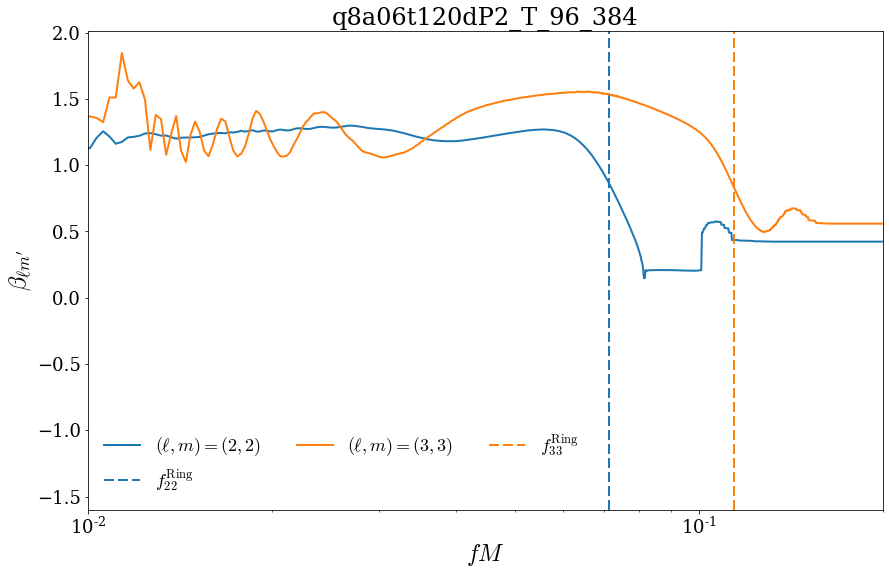

In [200]:


figure( figsize=2.2*figaspect(0.618) )

for l,m in lmlist2+lmlist3:
    if l==(m):
        if (l,m) in BETA:
            p=plot( (y['j'].f), -unwrap(BETA[l,m]), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )
            axvline( abs(y['j'][l,m]['psi4'].qnm_prograde_fring), ls='--',color=p[0].get_color(),lw=2,label=r'$f^\mathrm{Ring}_{%i%i}$'%(l,m) )
        if (l,m) in BETA3:
            p=plot( (y['j'].f), unwrap(BETA3[l,m]), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )
            axvline( abs(y['j'][l,m]['psi4'].qnm_prograde_fring), ls='--',color=p[0].get_color(),lw=2,label=r'$f^\mathrm{Ring}_{%i%i}$'%(l,m) )

# yscale('log')
legend(ncol=3,loc='best')
xscale('log')
xlabel('$f M$')
xlim(0.01,0.2)
ylabel(r"$\beta_{\ell m'}$")
title(y['j'].simname)
show()

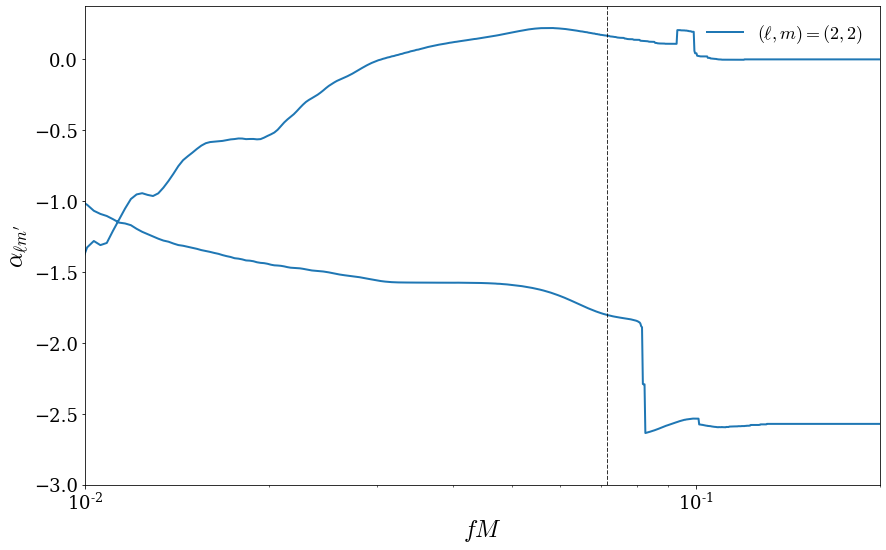

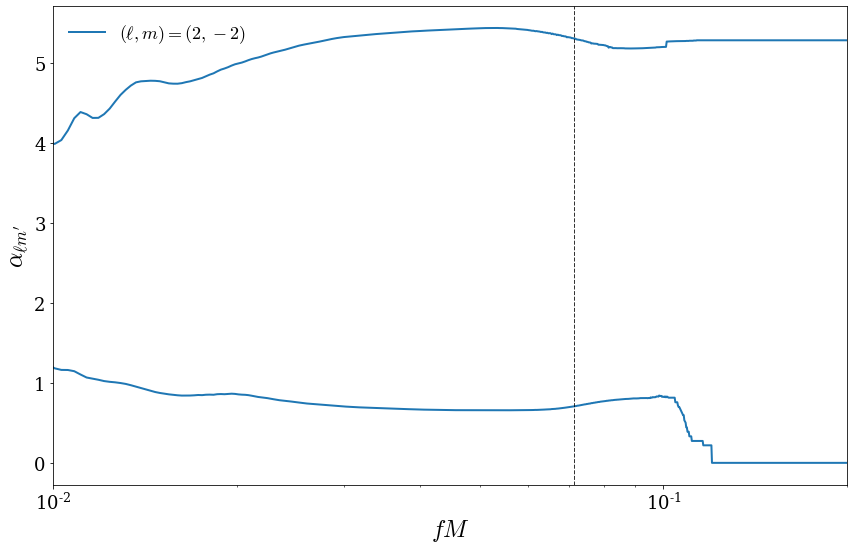

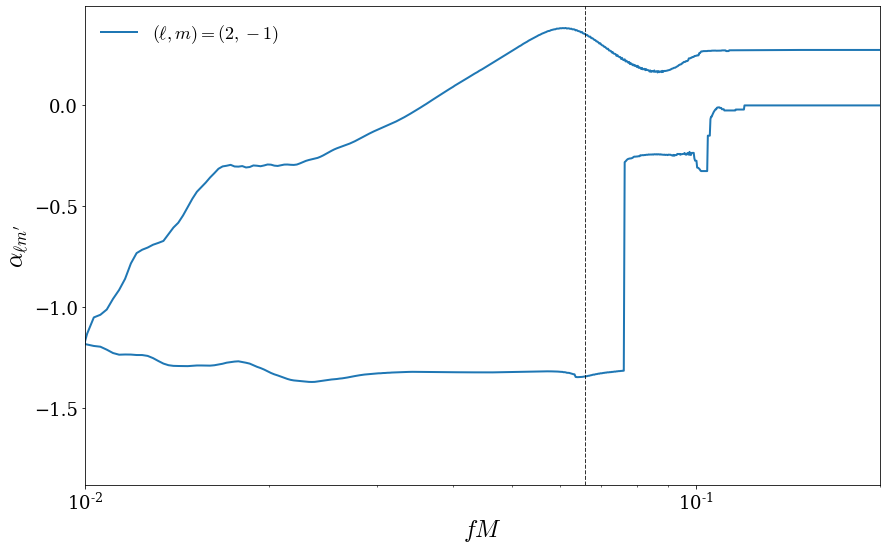

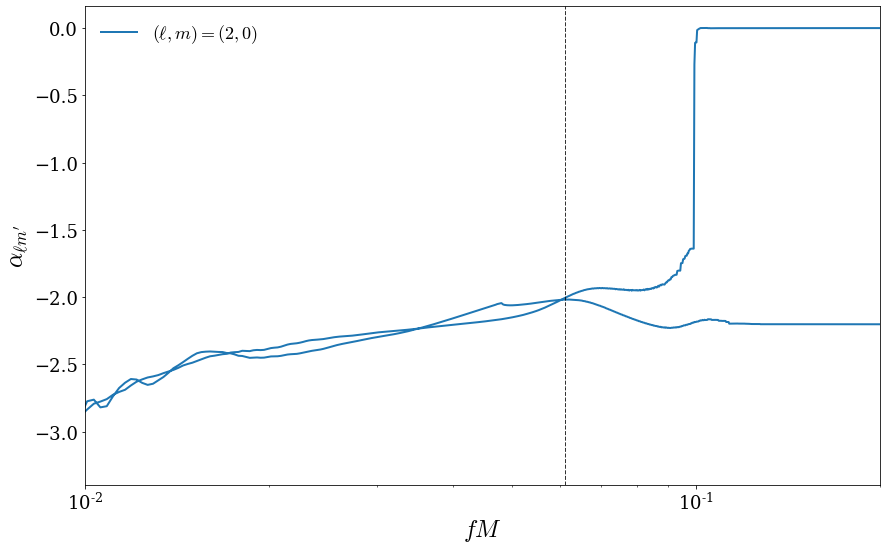

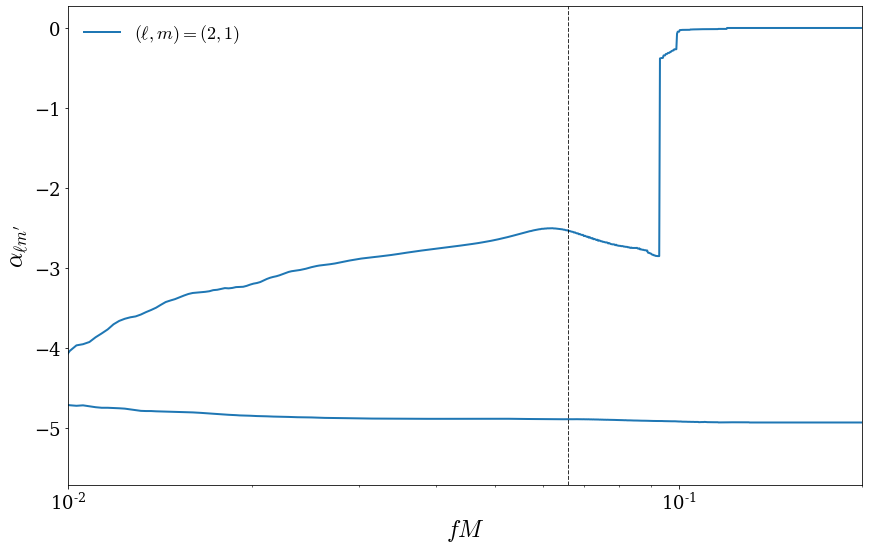

In [154]:



for l,m in lmlist:
    figure( figsize=2.2*figaspect(0.618) )
    plot( abs(y['j'].f), -unwrap(ALPHA[m]), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )
    axvline( abs(y['j'][l,m]['psi4'].qnm_prograde_fring), ls='--',color='k' )

    # yscale('log')
    legend(ncol=3,loc='best')
    xscale('log')
    xlabel('$f M$')
    xlim(0.01,0.2)
    ylabel(r"$\alpha_{\ell m'}$")
    show()

Text(0, 0.5, "$\\beta_{\\ell m'}$")

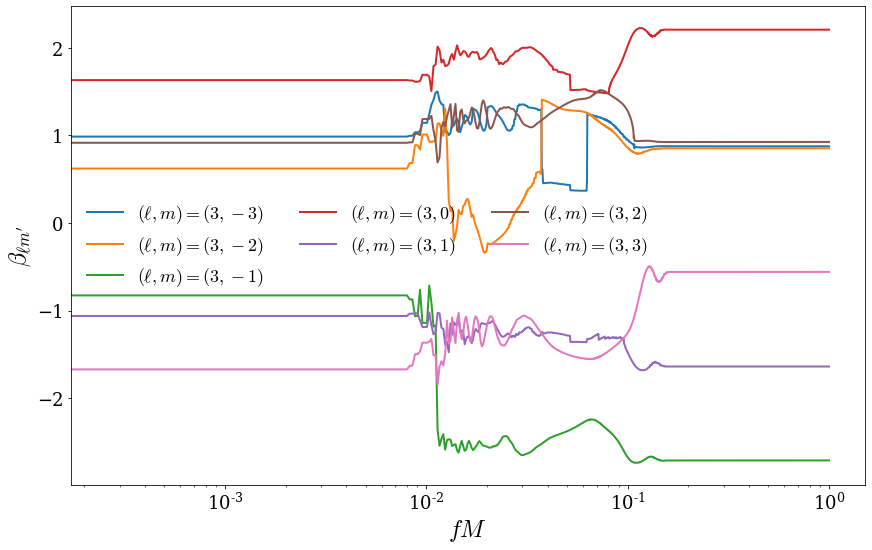

In [189]:

figure( figsize=2.2*figaspect(0.618) )

for l,m in lmlist3:
    plot (y['j'].f, -unwrap(BETA3[l,m]), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )

# yscale('log')
legend(ncol=3)
xscale('log')
xlabel('$f M$')
# xlim(0.01,0.2)
ylabel(r"$\beta_{\ell m'}$")

Text(0, 0.5, "$\\beta_{\\ell m'}$")

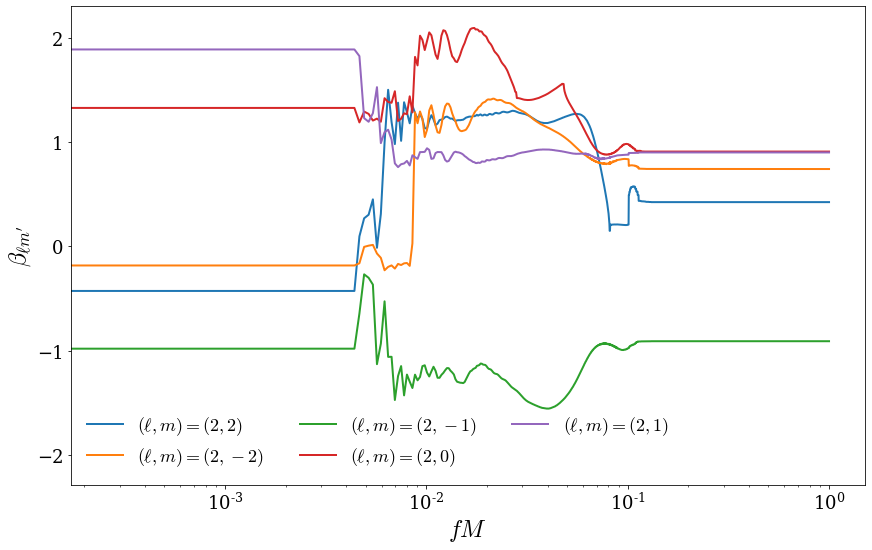

In [145]:

figure( figsize=2.2*figaspect(0.618) )

for l,m in lmlist:
    plot (y['j'].f, -unwrap(BETA[l,m]), lw=2, label=r'$(\ell,m)=(%i,%i)$'%(l,m) )

# yscale('log')
legend(ncol=3)
xscale('log')
xlabel('$f M$')
# xlim(0.01,0.2)
ylabel(r"$\beta_{\ell m'}$")

Text(0, 0.5, 'error estimate')

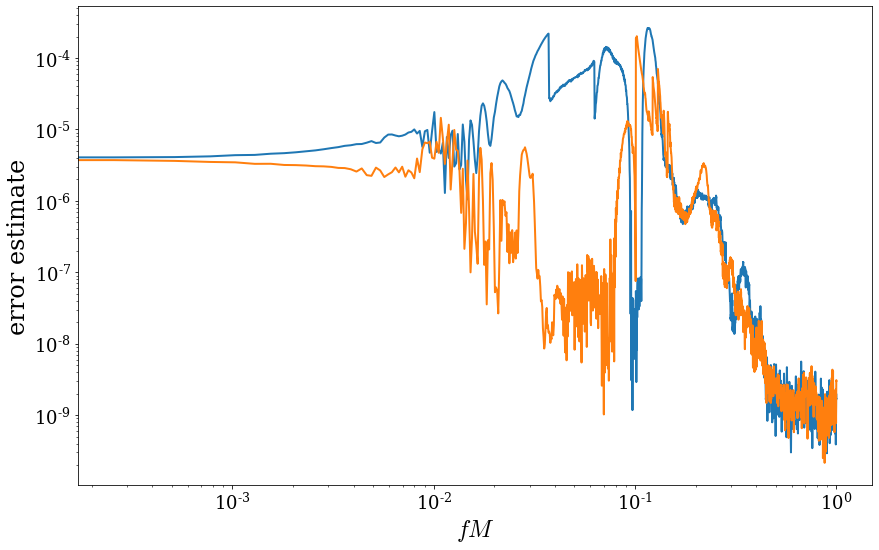

In [187]:
figure( figsize=2.2*figaspect(0.618) )
plot( y['j'].f,foo3[1],lw=2)
plot(-y['j'].f,foo3[1],lw=2)
yscale('log')
xscale('log')
xlabel('$f M$')
ylabel(r"error estimate")

Text(0, 0.5, 'error estimate')

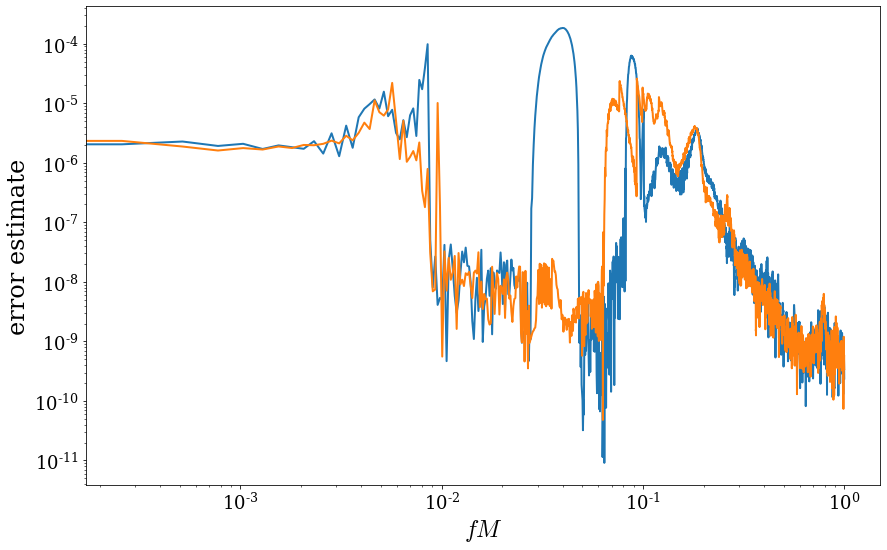

In [158]:
figure( figsize=2.2*figaspect(0.618) )
plot( y['j'].f,foo[1],lw=2)
plot(-y['j'].f,foo[1],lw=2)
yscale('log')
xscale('log')
xlabel('$f M$')
ylabel(r"error estimate")

In [10]:
# def calc_alterior_angles_helper( inertial_frame_gwylmo, l, kind='psi4' ):
#     '''
    
#     INPUTS
#     --
#     inertial_frame_gwylmo,   GWYLM clas object in an inertial frame appropriate for calculation of the coprecessing frame
#     l,                       Value of ell to consider - corresponds to l of single coprecessing frame moment
#     m,                       Value of emm to consider - corresponds to m of single coprecessing frame moment
#     kind='psi4',             Type of data to use
    
#     '''
    
#     #
#     from scipy.fftpack import fft, fftfreq, fftshift, ifft
#     from nrutils.manipulate.rotate import wdelement
    
#     #
#     FT = lambda X: fftshift( fft( X ) )
    
#     #
#     frame = {}
#     frame['input'] = inertial_frame_gwylmo
#     frame['cp']    = frame['input'].__calc_coprecessing_frame__(transform_domain='td',kind=kind)
    
#     #
#     radiation_axis_info = frame['cp'].previous_radiation_axis_info
#     alpha = radiation_axis_info.radiation_axis['td_alpha']
#     beta  = radiation_axis_info.radiation_axis['td_beta']
#     gamma = radiation_axis_info.radiation_axis['td_gamma']
    
#     #
#     tilde_bar_D_l_mmp = {}
#     tilde_bar_D_l_mmp_template = {}
#     mrange = list(range(-l,l+1))
    
#     for mp in mrange:
#         for m in mrange:

#             #
#             yp_lm = frame['cp'   ][l,m ][kind].y
            
#             # NOTE that if (alpha,beta,gamma) define the optimal emission direction in the inertial frame, 
#             # then (-gamma,-beta,-alpha) corresponds to the coprecessing frame's active rotation of the optimal emission direction along zed.
#             # -- 
#             D_l_mmp = wdelement(l,m,mp,-gamma,-beta,-alpha)

#             # NOTE that we here use the sameperspective for the rotation as used above; ie -G,-B,-A
#             tilde_bar_D_l_mmp_template[m,mp] = lambda A,B,G: wdelement(l,m,mp,-G,-B,-A)

#             #
#             y_lmp = frame['input'][l,mp][kind].y 

#             #
#             if not (len(D_l_mmp)==len(y_lmp)):
#                 error('leng mismatch:  len(D_l_mpm) =/= len(y_lm)')

#             #
#             tilde_bar_D_l_mmp[m,mp] = D_l_mmp # FT( y_lmp * D_l_mmp ) / FT( yp_lm )

      
#     #
#     foo = {}
#     foo['tilde_bar_D_l_mmp']          = tilde_bar_D_l_mmp
#     foo['tilde_bar_D_l_mmp_template'] = tilde_bar_D_l_mmp_template
#     foo['fd_domain']                  = inertial_frame_gwylmo.f
#     foo['td_alpha']                   = alpha
#     foo['td_beta']                    = beta
#     foo['td_gamma']                   = gamma
#     foo['mrange']                     = mrange
    
#     #
#     return foo

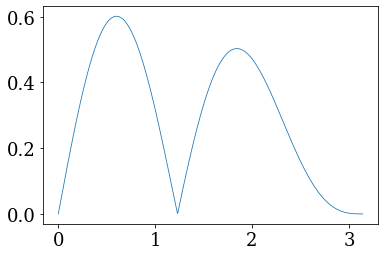

In [26]:
from nrutils.manipulate.rotate import wdelement
l,m,mp = 3,1,2
beta = linspace(0,pi,1e3)
dd = wdelement(l,m,mp,0*beta,beta,0*beta)
plot(beta,abs(dd))

In [11]:

l = 2
foo = calc_alterior_angles_helper( y['j'], l )

(calc_coprecessing_angles)>> The domain values seem unevenly split between positive and negative values. Thus, we will interpret the input as corresponding to TIME DOMAIN data.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


In [15]:


#
from scipy.optimize import minimize,root,curve_fit
from numpy.linalg import norm


#
k = int(0.75*len(foo['fd_domain']))

# Choose m'
mp = 1

# Given m', for all values of m, collect all tilde_bar_D_l_mmp[m,mp]
tilde_bar_D_l_mp = array([ foo['tilde_bar_D_l_mmp'][m,mp][k] for m in foo['mrange'] ])

domain        = foo['mrange']
training_data = tilde_bar_D_l_mp

# model  = lambda ABG: array([ foo['tilde_bar_D_l_mmp_template'][m,mp](*(array(ABG))) for m in foo['mrange'] ] )
# action = lambda ABG: sum(abs(training_data-model(ABG))**2)
# initial_guess = (0,0,0)
# mu = minimize( action, initial_guess  )
# popt = mu.x

model  = lambda x,A,B,G: array( [ foo['tilde_bar_D_l_mmp_template'][m,mp](A,B,G) for m in x ] )
initial_guess = (0,0,0)
mu = curve_fit( domain,model, initial_guess  )


plot( foo['mrange'], abs(training_data), marker='o', ls='none' )
plot( foo['mrange'], abs(model(domain,*popt)), marker='o', ls='none' )
xlabel('$m$')

print(mu)




TypeError: [-2, -1, 0, 1, 2] is not a callable object

      fun: 4.405947770787349
 hess_inv: array([[ 0.60530129,  0.        , -0.39469871],
       [ 0.        ,  1.        ,  0.        ],
       [-0.39469871,  0.        ,  0.60530129]])
      jac: array([-1.78813934e-07,  0.00000000e+00, -1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-0.39269912,  0.        , -0.39269912])


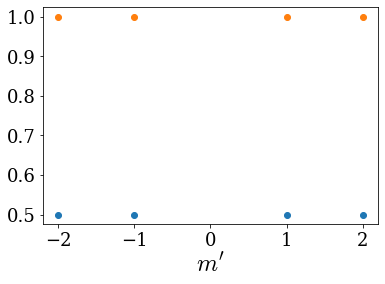

In [258]:


#
from scipy.optimize import minimize,root,curve_fit
from numpy.linalg import norm


#
k = int(0.75*len(foo['fd_domain']))

# Choose m'
mp = 1

# Given m', for all values of m, collect all tilde_bar_D_l_mmp[m,mp]
tilde_bar_D_l_mp = array([ foo['tilde_bar_D_l_mmp'][m,mp][k] for m in foo['mrange'] if m!=0 ])

domain        = foo['mrange']
training_data = tilde_bar_D_l_mp

model  = lambda ABG: array([ foo['tilde_bar_D_l_mmp_template'][m,mp](*(array(ABG))) for m in foo['mrange'] if m!=0 ] )
action = lambda ABG: sum(abs(training_data-model(ABG))**2)

initial_guess = (0,0,0)
mu = minimize( action, initial_guess  )


plot( [ m for m in foo['mrange'] if m!=0 ], abs(training_data), marker='o', ls='none' )
plot( [ m for m in foo['mrange'] if m!=0 ], abs(model(mu.x)), marker='o', ls='none' )
xlabel('$m\'$')

print(mu)





(notebook)>> (0, 0, 0)


/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


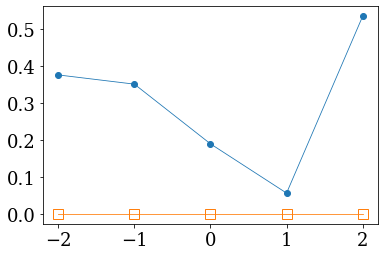

In [210]:


#
from scipy.optimize import minimize,root,curve_fit
from numpy.linalg import norm

index_range = list(range( len(foo['fd_domain']) ))
alt_alpha = []
alt_beta  = []
alt_gamma = []
alt_res   = []

for k in index_range:# [int(0.75*len(foo['fd_domain']))]:
    #index_range:for k in index_range:
    # for k in index_range:
    
    #                                                        
    action = lambda MP,A,B,G: array([abs(foo['tilde_bar_D_l_mmp_template'][mp](A,B,G)) for mp in MP])
    initial_guess = (0,0,0) if k==0 else (alt_alpha[k-1],alt_beta[k-1],alt_gamma[k-1])
    angle_bounds  = (0,2*pi)
    xdata = foo['mprange']
    ydata = array([ abs(foo['tilde_bar_D_l_mmp'][mp][k]) for mp in foo['mprange'] ])
    popt,pcov = curve_fit( action, xdata, ydata, p0=initial_guess )
    popt = initial_guess
    
    #
    alpha_k, beta_k, gamma_k = popt
    alt_alpha.append( alpha_k )
    alt_beta. append( beta_k )
    alt_gamma.append( gamma_k )
    alt_res.  append( (ydata-action(xdata,*popt)) )
    #print((ydata-action(xdata,*popt)))
    #break
    
    # alert(popt)
    # plot( xdata,ydata,'-o' )
    # plot( xdata,action(xdata,*popt),'-s',ms=10,mfc='none' )
    # 
    # break
    
    # #                                                        
    # # action = lambda ABG:  array([abs(foo['tilde_bar_D_l_mmp_template'][mp](ABG[0],ABG[1],ABG[2])) for mp in foo['mprange']])
    # action = lambda ABG: norm(  foo['residuals_template'](k,ABG[0],ABG[1],ABG[2])  )
    # initial_guess = ( foo['td_alpha'][k], foo['td_beta'][k], foo['td_gamma'][k]) #(0,0,0)# if k==0 else (alt_alpha[k-1],alt_beta[k-1],alt_gamma[k-1])
    # angle_bounds  = None#[ (0,2*pi), (0,pi), (0,2*pi) ]
    # mu = minimize( action, initial_guess  )
    # 
    # # #                                                 -Gamma  -Beta  -Alpha
    # # action = lambda ABG: foo['residuals_template'](k,-ABG[2],-ABG[1],-ABG[0])[:3]
    # # initial_guess = (0,0,0)
    # # mu = root( action, initial_guess  )
    # print(mu)
    # 
    # #
    # alpha_k, beta_k, gamma_k = mu.x
    # alt_alpha.append( alpha_k )
    # alt_beta. append( beta_k )
    # alt_gamma.append( gamma_k )
    # alt_res.  append( mu.fun )
    # 
    # plot( foo['mprange'], array([ abs(foo['tilde_bar_D_l_mmp'][mp][k]) for mp in foo['mprange'] ]), '-o' )
    # plot( foo['mprange'], array([ abs(foo['tilde_bar_D_l_mmp_template'][mp](*mu.x)) for mp in foo['mprange'] ]),'-s',ms=10,mfc='none' )


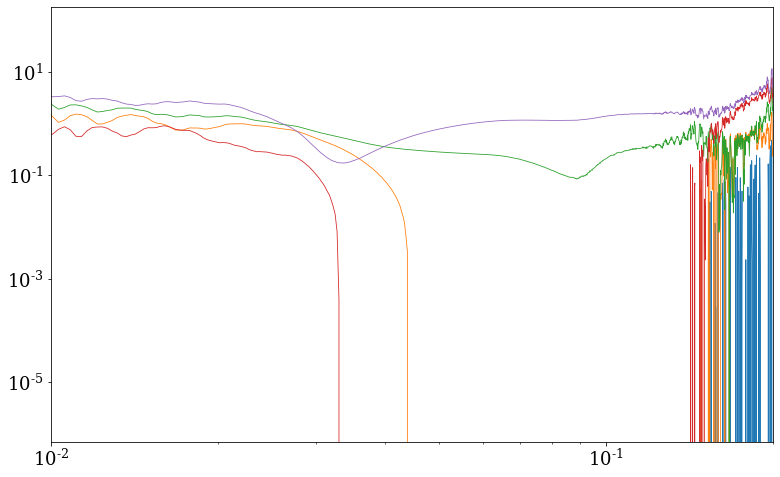

In [193]:
figure( figsize=2*figaspect(0.618) )

xx = foo['fd_domain']
yy = array(alt_res)

plot( xx, yy )
xlim(0.01,0.2)
xscale('log')
yscale('log')
# ylim( lim( yy[ (xx>min(xlim())) & (xx<max(xlim())) ] ) )

(1.2600967533676402, 1.854262102966194)

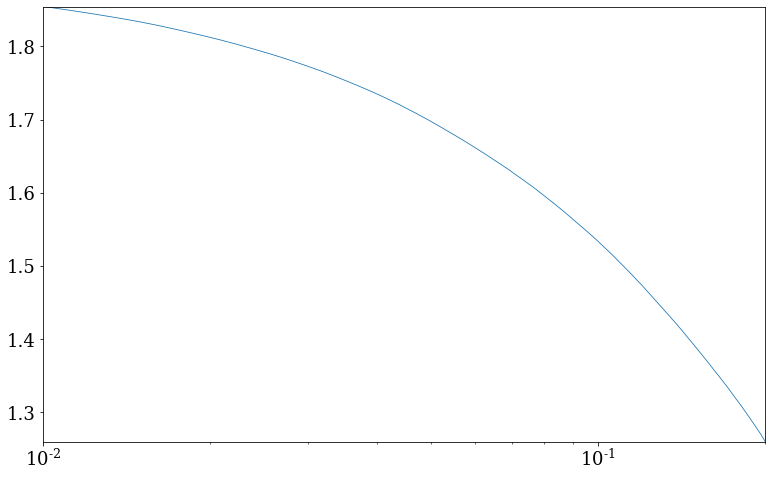

In [196]:
figure( figsize=2*figaspect(0.618) )

xx = -foo['fd_domain']
yy = unwrap(alt_alpha)

plot( xx, yy )
xlim(0.01,0.2)
xscale('log')
ylim( lim( yy[ (xx>min(xlim())) & (xx<max(xlim())) ] ) )

(1.1924411218549158, 1.2114882794575896)

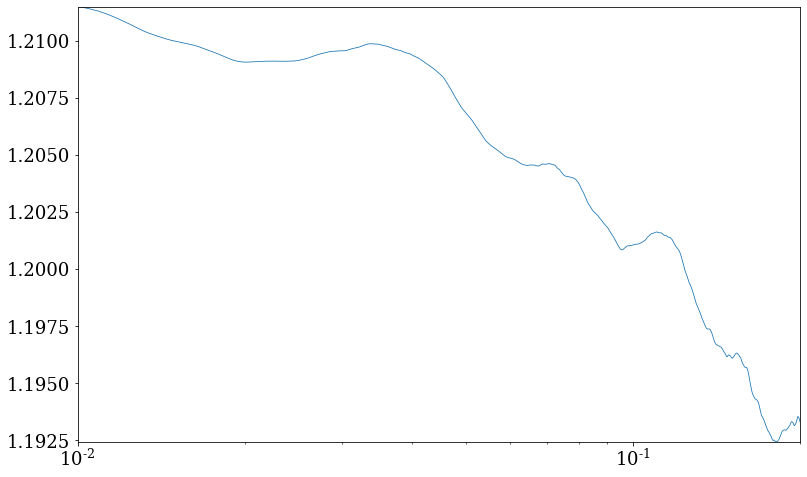

In [197]:
figure( figsize=2*figaspect(0.618) )

xx = -foo['fd_domain']
yy = unwrap(alt_beta)

plot( xx, yy )
xlim(0.01,0.2)
xscale('log')
ylim( lim( yy[ (xx>min(xlim())) & (xx<max(xlim())) ] ) )

(-0.6683552406351918, -0.4541084080444555)

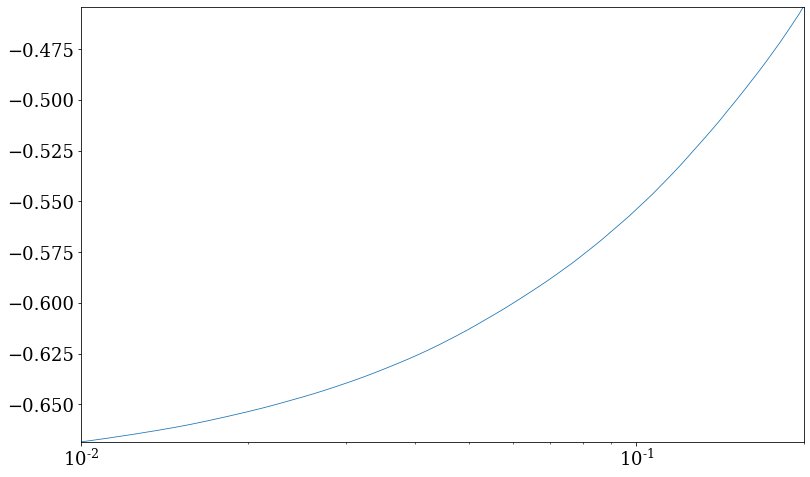

In [199]:
figure( figsize=2*figaspect(0.618) )

xx = -foo['fd_domain']
yy = unwrap(alt_gamma)

plot( xx, yy )
xlim(0.01,0.2)
xscale('log')
ylim( lim( yy[ (xx>min(xlim())) & (xx<max(xlim())) ] ) )